# Trabajo Final de Estructura 3

Nicolas Unger

## Resolver la ecuacion de Schrödinger con un metodo numerico que usa los polinomios de Chebychev

Para este trabajo me voy a basar en el paper de Rawitscher.

"An efficient numerical spectral method for solving the Schrodinger equation," in Computing in Science & Engineering, vol. 7, no. 6, pp. 58-66, Nov.-Dec. 2005.

El metodo que usa Rawitscher es bastante complicado y me tomo bastante tiempo entender cada paso y asi poder modificar el programa de matlab y aplicarlo a otros casos.

Voy a tratar de dar una descripcion general del metodo sin entrar con mucho detalle en las cuentas.

## Descripcion del metodo

Toda funcion se puede expresar como una combinacion lineal de polinomios de Chebychev en el intervalo [-1,1]

\begin{equation}
f(x) = \frac{a_0}{2} + \sum_{j=1}^{\infty} a_j T_j(x)
\end{equation}

Siendo $T_j(x)$ el polinomio de chebychev de orden $j$.

Se puede mostrar que en esta expansion los valores de $a_j$ convergen muy rapido a $0$ para ordenes mayores de $j$. Esto significa que el error que se comete al cortar la expasion en un dado valor j es muy bajo y no se introducen anomalias como el fenomeno de Gibbs. Entonces se puede escribir nuestra funcion como una expansion truncada:

\begin{equation}
f_N(x) = \frac{a_0}{2} + \sum_{j=1}^{N} a_j T_j(x)
\end{equation}

Para obtener los valores $a_j$ se usan unas matrices $S_L$ y $S_R$ que estan descriptas en el paper y se calculan con la funcion SL_SR.m de MATLAB.

La ecuacion de Schrödinger a resolver es: 

\begin{equation}
\left( \frac{d^2}{dr^2} + k^2 \right) \psi = V \psi
\end{equation}

Pero en este caso es mas facil resolver la ecuacion integral equivalente de Lippmann-Schwinger (L-S):

\begin{equation}
\psi(r) = sin(kr) + \int_0^T G_0(r,r')V(r')\psi(r')dr'
\end{equation}

donde $G_0$ es la funcion de Green.

A partir de acá utilizan una version del metodo de S-IEM para resolver la ecuación de L-S.
Consiste en partir el intervalo radial $0<r<T$ en particiones y resolver la ecuacion de L-S para cada una de esas particiones obteniendo dos soluciones especiales llamadas $Y(r)$ y $Z(r)$. Estas soluciones se obtienen expandiendolas en terminos de los polinomios de Chebychev. Para esto se usan los ceros del polinomio de Chebychev de orden mas alto, e integrales parciales de estas funciones. Este proceso se hace en los programas C_CM1.m y YZ.m. El tamaño de cada particion se determina con un criterio de convergencia tal que los ultimos terminos de la expansion de $Y(r)$ y $Z(r)$ no superen cierta tolerancia (del orden de 1e-12). De esta forma se van obtiendo los limites inferiores $b_{i-1}$ y superiores $b_i$ de cada particion hasta llegar a un valor limite $T$ predefinido. Estos limites se van obteniendo llamando a la funcion meshiem.m.

Una vez obtenidas las funciones $Y(r)$ y $Z(r)$ para cada particion, la funcion de onda global se arma como una combinacion lineal de Y y Z en cada particion. Es decir:

\begin{equation}
\psi(r) = A_i Y_i(r) + B_i Z_i(r), \quad b_{i-1}\le r \le b_i
\end{equation}

Los valores de $A_i$ y $B_i$ se obtienen teniendo en cuenta que la funcion de onda global tiene que ser continua en la funcion y en la derivada. Entonces se pega cada particion para que coincidan $\psi$ y la derivada.

## Objetivo

El primer objetivo del trabajo fue entender el metodo y el codigo correspondiente. Despues es modificar el codigo provisto por Rawitscher para poder analizar otros casos y no solo el caso especifico que analizo el.

Para eso tuve que cambiar el potencial del de Morse al de Coulomb y los valores de energia a analizar. Dado que no estaba hecho por el autor original, tambien tuve que crear una subrutina que genere la funcion de onda global a partir de las descomposiciones en polinomios de chebychev de $Y(r)$ y $Z(r)$ para cada particion. Todo esto no fue tan facil como suena porque el programa esta escrito de una forma poco legible con nombres de variables bastante confusos y tenia que estar seguro de como funciona el programa antes de cambiar algo para saber que no estoy rompiendo nada.

Tambien optimice el programa original sacando calculos innecesarios y preallocando la memoria de los vectores y matrices para alivianar el trabajo de MATLAB. Con esos simples cambios logre que el programa corra 3 veces mas rapido.

Use el ejemplo que habia hecho en la Guia 2, del espectro continuo de un electron en el atomo de Litio para un numero de onda de k=2.3

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Estática
sp.init_printing()
%matplotlib inline

#Definimos los simbolos que vamos a usar.
r = sp.Symbol('r',positive=True)
l = sp.Symbol('l',positive=True,integer=True)
z = sp.Symbol('z',positive=True,integer=True)
k = sp.Symbol('k',positive=True)   # k en lugar de n 

In [2]:
# Función Radial Hidrogénica -- Estados del Continuo (con hipergeométricas)

def R_analytic(k,l,z,r):
    
    a = z/k # Parámetro de Sommerfeld
     
    # Generalización al campo complejo
    nj = 1j*a  
    rho = -2*1j*k*r
   
    # Los continuos se normalizan de otra forma
    rnum = (2*z/nj)**3 * sp.gamma(nj+l+1)
    rden = (sp.gamma(2*l+2))**2 * 2*nj * sp.gamma(nj-l)
    rnorm = sp.sqrt(rnum/rden)

    rfunc = 1j**l * (rho)**l * sp.exp(-rho/2) * sp.hyper((-nj+l+1,),(2*l+2,),(rho))
    return rfunc

In [3]:
# Definición de los vectores a plotear
    
nsize = 1000
xmax = 20.0
xmin = 0.01
x = np.linspace(xmin,xmax,nsize)
psi = np.zeros(nsize,dtype=complex)

In [4]:
# Copiamos el array simbólico a numérico

# Variables de mi funcion
kq = 2.3
lq = 0
zq = 3

for i in range(nsize):
    psi[i]= R_analytic(kq,lq,zq,x[i]).evalf()

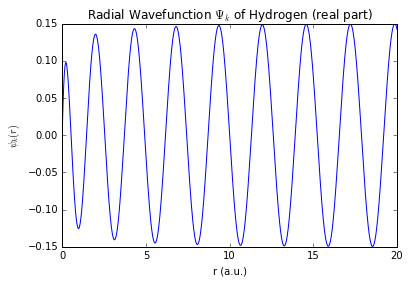

In [5]:
# Ploteo
plt.plot(x,x*psi.real);
plt.title("Radial Wavefunction $\Psi_{k}$ of Hydrogen (real part)");
plt.xlabel("r (a.u.)");
plt.ylabel("$\psi_{k}(r)$");
plt.show()

## Hago lo mismo pero con el metodo espectral de Rawitscher

Calculo fue hecho en MATLAB basandome en el programa provisto por Rawitscher. Importo aca las soluciones de la ecuacion de onda.

Use las mismas condiciones:
k = 2.3;
z = 3;
l = 0;

In [6]:
# Importo los datos obtenidos con el programa de MATLAB

psi_mat = np.loadtxt('psi_k23_C.csv', delimiter=',')
            
r_mat = np.loadtxt('r_k23_C.csv', delimiter=',')

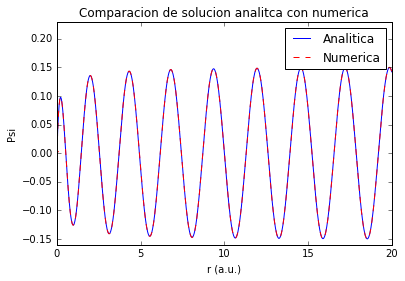

In [7]:
c = 0.423

plt.plot(x,x*psi.real, label='Analitica')
plt.plot(r_mat,c*psi_mat,'r--', label='Numerica')

plt.title("Comparacion de solucion analitca con numerica")
plt.ylim([-0.16,0.23])
plt.xlabel('r (a.u.)')
plt.ylabel('Psi')
plt.legend()
plt.show()

A menos de una constante multiplicativa coinciden muy bien. Se debe a la normalizacion.. en el Apendice 3 del paper describe un metodo para encontrar la normalizacion de $\psi$ pero no lo entendi. Porque te da una condicion que tienen que cumplir los $A_i$ y $B_i$, pero yo solo note que te puede dar una condicion para el utlimo $A_i$ en vez del primero (que es la idea).

#### Mas ejemplos

In [8]:
k = [2.3, 2.8, 3.3]

In [9]:
# Solucion Numerica

path = "Datos_Coulomb\\"

psi_k_num = []
r_k_num = []

for i in range(3):
    psi_k_num.append(np.loadtxt(path + "psi_k"+str(i)+".csv", delimiter=','))
    r_k_num.append(np.loadtxt(path + "r_k"+str(i)+".csv", delimiter=','))

In [10]:
# Solucion Analitica

psi_k_aly = np.zeros([3,nsize], dtype=complex)

for i in range(3):
    for j in range(nsize):
        psi_k_aly[i][j] = x[j] * R_analytic(k[i],lq,zq,x[j]).evalf()

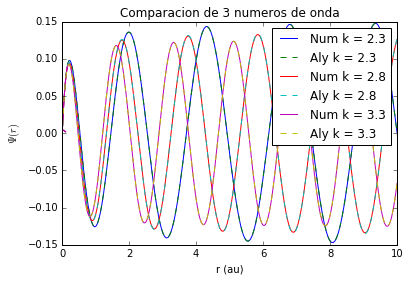

In [12]:
c = [0.423, 0.345, 0.295]

for i in range(3):
    plt.plot(r_k_num[i], c[i]*psi_k_num[i], label="Num k = "+str(k[i]))
    plt.plot(x, psi_k_aly[i].real, '--', label="Aly k = "+str(k[i]))
    
plt.xlim([0, 10])
plt.xlabel("r (au)")
plt.ylabel("$\Psi(r)$")
plt.title("Comparacion de 3 numeros de onda")
plt.legend()
plt.show()

Al igual que antes, a menos constantes multiplicativas, las soluciones numericas y analiticas caen perfectamente una arriba de la otra.

## Resolucion del espectro vibracional para la molecula $H_2$

Ahora voy a resolver la ecuacion de Schrödinger para la molecula de Hidrogeno $H_2$ usando el potencial de Morse. Como existe la solucion analitica la voy a usar para comparar con el metodo numerico.

Potencial de Morse:

\begin{equation}
V(r) = D_e \left[ e^{-2\alpha(r-R_0)} - 2 e^{-\alpha(r-R_0)} \right ]
\end{equation}

donde $D_e = 0.175$, $\alpha = 1.03$ y $R_0 = 1.4$ para la molecula de $H_2$.

Las autoenergias estan dadas por:

\begin{equation}
E_n = \omega_0 \left(n + \frac{1}{2}\right) - \frac{1}{4D_e}\left[ \omega_0 \left(n + \frac{1}{2}\right) \right]^2
\end{equation}

donde $\omega_0 = \sqrt{ \frac{2D_e\alpha^2}{\mu}}$ y $\mu$ es la masa reducida de ambos atomos. Pero como en este caso es el mismo atomo, $\mu = M/2$

In [13]:
from scipy.special import gamma, hyp1f1
from math import factorial

In [14]:
# Solucion analitica de la ecuacion de Schrödinger con el potencial de Morse
# Fuente: The Journal of Chemical Physics 88, 4535 (1988)

def PsiMorse(x,n,xe,lamda):
    """ Solucion analitica de la ecuaicon de Schrödinger con un potencial de Morse. """
    z = 2*lamda*np.exp(-(x-xe))
    
    return Nn(n, lamda) * z**(lamda-n-0.5) * np.exp(-0.5*z) * Ln(n, 2*lamda - 2*n - 1, z)

def Nn(n, lamda):
    """ Funcion N de la solucion de Morse. """
    num = factorial(n) * (2*lamda - 2*n - 1)
    den = gamma(2*lamda - n)
    return np.sqrt(num/den)

def Ln(n, alpha, z):
    """ Polinomio de Laguerre generalizado. """
    num = gamma(alpha + n +1)
    den = gamma(alpha + 1)*factorial(n)
    return (num/den) * hyp1f1(-n, alpha+1, z)

In [15]:
De = 0.175 # Poso del potencial
alpha = 1.03
R0 = 1.4 # R del minimo
xe = alpha*R0
mu = 1837/2 # Masa reducida
lamda = np.sqrt(2*mu*De)/alpha
grid = x*alpha

psi_m_anly = PsiMorse(grid, 8, xe, lamda)

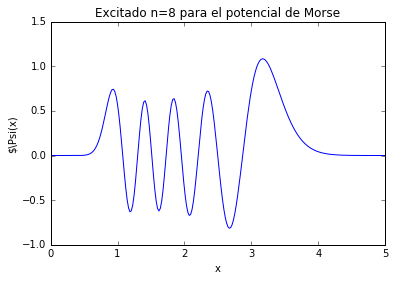

In [16]:
plt.plot(grid, psi_m_anly)
plt.xlim([0,5])
plt.xlabel("x")
plt.ylabel("$\Psi(x)")
plt.title("Excitado n=8 para el potencial de Morse")
plt.show()

### Importo los datos de Matlab

In [17]:
psi_mat_n0 = np.loadtxt('psi_morse_n0.csv', delimiter=',')  
r_mat_n0 = np.loadtxt('r_morse_n0.csv', delimiter=',')

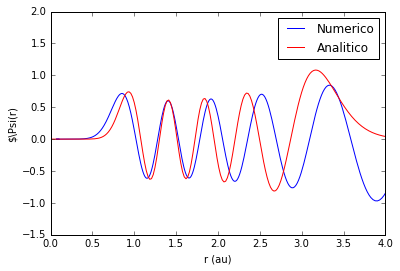

In [18]:
norm = 1./4900 # Valor de normalizacion para que las dos soluciones sean del mismo orden de magnitud

plt.plot(r_mat_n0, norm*psi_mat_n0, label="Numerico")
plt.plot(grid, psi_m_anly, 'r', label="Analitico")
plt.xlim([0,4])
plt.ylim([-1.5,2])
plt.xlabel("r (au)")
plt.ylabel("$\Psi(r)")
plt.legend()
plt.show()

Aca el resultado es mas extraño. Como era de esperar la normalizacion de la solucion esta mal y la ajusté para que coincida con la analitica. Un par de cosas a notar aca es que la energia de la solucion numerica es la del estado fundamental, pero por cantidad de picos coincide recien con la del excitado n=8. Igualmente el unico pico que coincide es el que esta en $r\approx1.4$ que es justo el $R_0$ y el resto parecen estirarse a partir de ese punto. Esto se puede deber a como resolvi la ecuacion numericamente y como esta construida la solucion analitica.

Dos cosas extrañas mas que note, es que la solucion numerica nunca converge a 0 para $r \to \infty$, si no que se convierte en una solucion oscilatoria (ver grafico mas adelante). Y por otro lado para los distintos niveles de energia, la solucion numerica siempre sale con la misma forma.

### Comparacion de soluciones numericas

Calculé la solucion de este problema para las autoenergias hasta n=8, y despues muestro todos los graficos juntos.

In [19]:
path = "Datos_Morse\\"

psi_mat = []
r_mat = []

# Importo todas las soluciones a la misma lista para poder iterar sobre ella
for i in range(9):
    psi_mat.append(np.loadtxt(path + 'psi_morse_n'+str(i)+'.csv', delimiter=',')) 
    r_mat.append(np.loadtxt(path + 'r_morse_n'+str(i)+'.csv', delimiter=','))

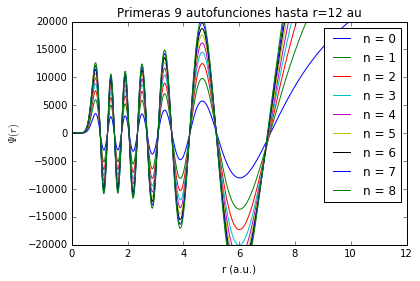

In [20]:
# Ploteo todas las soluciones al mismo tiempo

for i in range(9):
    plt.plot(r_mat[i], psi_mat[i], label="n = "+str(i))
    
plt.legend()
plt.xlim([0,12])
plt.ylim([-20000,20000])
plt.xlabel("r (a.u.)")
plt.ylabel("$\Psi(r)$")
plt.title("Primeras 9 autofunciones hasta r=12 au")
plt.show()

Se puede ver que hasta $r\approx8$ todas las soluciones coinciden a menos de una constante multiplicativa. Los ceros y picos estan todos en el mismo lugar.

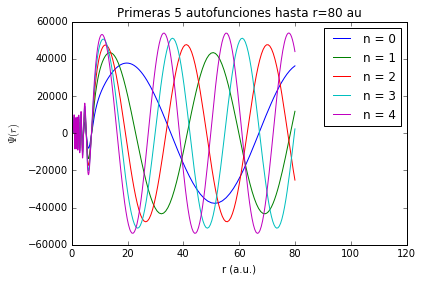

In [21]:
for i in range(5):
    plt.plot(r_mat[i], psi_mat[i], label="n = "+str(i))
    
plt.legend()
plt.xlim([0,120])
#plt.ylim([-20000,20000])
plt.xlabel("r (a.u.)")
plt.ylabel("$\Psi(r)$")
plt.title("Primeras 5 autofunciones hasta r=80 au")
plt.show()

Aca grafique solo 5 para que se vea mejor.

Se puede ver bien como todas tienden a una solucion oscilatoria, pero con frecuencias distintas. Especificamente frecuencias mas altas para energias mayores.

Probablemente este algoritmo no pueda crear soluciones ligadas, por eso siempre terminan en una solucion oscilatoria.
Al principio queria resolver la ecuacion de Schrödinger para el atomo de hidrogeno en los estados ligados, pero rapidamente me di cuenta que no era posible. En el paper mismo dice que solo funciona para energias positivas (k reales).

De hecho en soluciones del continuo funciona muy bien y es muy rapido (hasta distancias radiales muy grandes corre en menos de 1 segundo) como mostre en el ejemplo de Hidrogeno continuo, y el ejemplo de scattering que dan en el paper.